**SETUP INSTRUCTIONS**

Run each cell below to set up the environment. Make sure to adjust the subject ID and path variables.
Run pupilLabsDebug BEFORE this program to ensure measurements are as expected.

In [2]:
path_base = 'C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/'
# can add subject number + date
subject_id = 3
subj_base = 'plr-90s-binoc-sub-003_ses-02_dat-20230714' # plr-ISI-sub-subjectID-ses-sesID-dat-date - sub-xxx-ses-xx-dat-yyyymmdd

In [3]:
# Set up stlab
from pyplr import stlab
d = stlab.SpectraTuneLab(password='2294b16eea08a15a')
d.turn_off()

LIGHT HUB login success
User authenticated as: admin
The following addresses are defined: [1, 1004, 1023]
Call get_luminaires() / get_device_info() for more info


<Response [200]>

Light engine is now set up, and so it is now possible to access the methods from the REST API. 

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:368: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for led, df in self.data.groupby(["led"]):
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is de

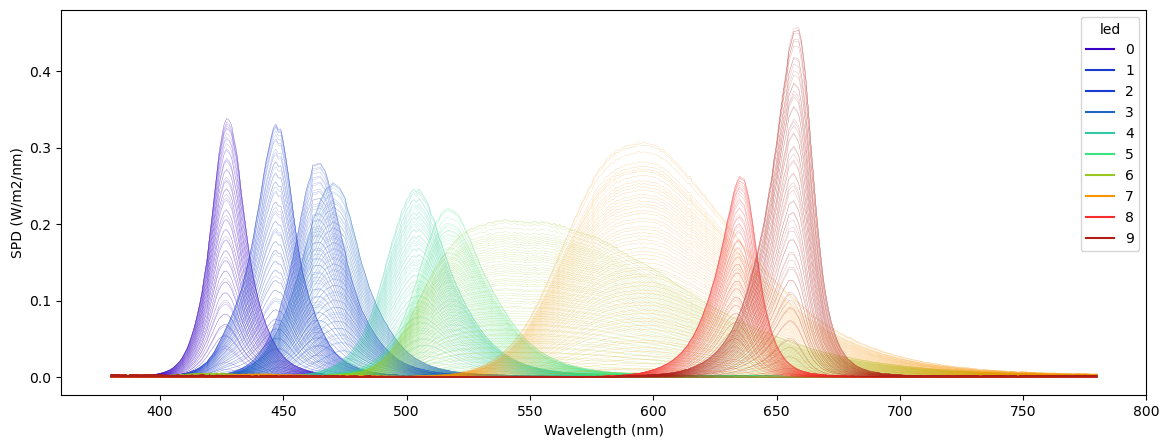

In [5]:
# from pyplr.calibrate import CalibrationContext as calibrationContext
# Calibration - important
import pyplr.calibrate as calb
from importlib import reload
reload(calb)
# file type to be read must be in format of:
# led | intensity | wavelength 1 (380) | wavelength 2 | ... | wavelength n (780)

cc = calb.CalibrationContext(
    'S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()


In [6]:
# calculate the peak spectral sensitivity for each LED at its maximum intensity setting
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

led
0    427
1    447
2    465
3    470
4    505
5    517
6    540
7    594
8    635
9    659
dtype: int64

In [7]:
from pyplr import stlab

#50mW spec - retrieved from examples/pfr/stimuli/PLR-3000-50-mw.dsf
white_spec = [176, 184, 80, 0, 0, 0, 308, 122, 0, 0]
d.turn_off()

<Response [200]>

In [8]:
from time import sleep
# import random # not using this library unless we want to randomize stims
from pyplr.pupil import PupilCore
from pyplr.utils import unpack_data_pandas
from pyplr.protocol import input_subject_id, subject_dir
# Connect to Pupil Core
p = PupilCore()
p.check_3d_model()

> Refit the 3d model? [y/n]: y
> Unfreezing 3d model for eye 0
> Unfreezing 3d model for eye 1
> Ask the participant to roll their eyes
> Press "Enter" when ready to freeze the model: 
> Freezing 3d model for eye 0
> Freezing 3d model for eye 1


Please enter subject ID: 003
> Grabbing 300 seconds of pupil.1.3d
> Grabbing 300 seconds of pupil.0.3d
> Waiting for a light to stamp...
> Light stamped on frame.world at 168155.858731
> Waiting for a light to stamp...
> Light stamped on frame.world at 168247.42773
> Waiting for a light to stamp...
> Light stamped on frame.world at 168338.855504
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
> PupilGrabber done grabbing 300 seconds of pupil.1.3d
> PupilGrabber done grabbing 300 seconds of p

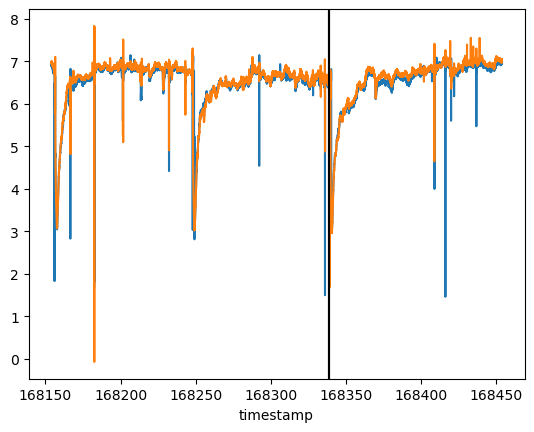

In [9]:
# PIPR STIMS - USE THIS ONE
d.turn_off()
subject_id = input_subject_id()
subj_dir = subject_dir(subject_id)
sleep(2)
ISI = 85 # interstimulus time, in seconds
num_trials = 3 # total number of trials
run_time = ISI*num_trials + 5*num_trials + 30 # appropriate offset to account for stim duration + sleeps


# Start a new recording called "my_recording"
p.command('R my_recording')

# Wait a few seconds
sleep(2)

# Make an annotation for when the light comes on
annotation = p.new_annotation('LIGHT_ON')

# Start the .light_stamper(...) and .pupil_grabber(...)
# this only captures one eye
# pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=25) # time here is TOTAL run time
pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=run_time) # time here is TOTAL run time
pgr_future2 = p.pupil_grabber(topic='pupil.0.3d', seconds=run_time) # time here is TOTAL run time

sleep(2)
##################################
# Administer light stimulus here #
i = 0
# random.shuffle(led_list) # use this if stims should be randomized
while (i < num_trials):
    intensities = white_spec
    lst_future = p.light_stamper(annotation=annotation, timeout=10)
    d.set_spectrum_a(intensities)
    sleep(1.)
    d.turn_off()
    sleep(ISI)
    i+=1
    sleep(5) # make sure there is extra time so that trials do not overlap
##################################

# Wait for the futures
while lst_future.running() or pgr_future.running() or pgr_future2.running():
    print('Waiting for futures...')
    sleep(1)

# End recording
p.command('r')

# Get the timestamp and pupil data
timestamp = lst_future.result()[1]
data = unpack_data_pandas(pgr_future.result())
data2 = unpack_data_pandas(pgr_future2.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax = data['diameter_3d'].plot()
ax.axvline(x=timestamp, color='k')
ax2 = data2['diameter_3d'].plot()
ax2.axvline(x=timestamp, color='k')

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
168153.756911,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3047212624888601, 0.8471344231312244]",62.934480,0.930067,"{'center': [0.6090421979376388, -6.03335330235...","{'center': [99.76600351790097, 57.077185801868...","{'center': [-4.320419921530036, -7.96785072342...",6.921439,"{'center': [58.50648239786114, 29.350190758804...","[58.50648239786114, 29.3501907588049]",1.0,1.758036,-2.074618
168153.780755,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3039763542743288, 0.8462238429732819]",62.681912,0.926555,"{'center': [0.6090421979376388, -6.03335330235...","{'center': [99.76600351790097, 57.077185801868...","{'center': [-4.336298358433183, -7.94818883945...",6.892089,"{'center': [58.36346002067113, 29.525022149129...","[58.36346002067113, 29.525022149129867]",1.0,1.756110,-2.076194
168153.804557,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.304380296182034, 0.8465320918273259]",63.006313,0.884103,"{'center': [0.6090421979376388, -6.03335330235...","{'center': [99.76600351790097, 57.077185801868...","{'center': [-4.328557923153333, -7.95482654741...",6.930217,"{'center': [58.44101686695053, 29.465838369153...","[58.44101686695053, 29.465838369153417]",1.0,1.756760,-2.075395
168153.820898,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.30413021593445483, 0.8465442741319331]",62.871865,0.905433,"{'center': [0.6090421979376388, -6.03335330235...","{'center': [99.76600351790097, 57.077185801868...","{'center': [-4.33371392437809, -7.955518334864...",6.914591,"{'center': [58.39300145941532, 29.463499366668...","[58.39300145941532, 29.46349936666884]",1.0,1.756828,-2.075979
168153.840129,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.30437174935413114, 0.8462071333939555]",63.024483,0.962568,"{'center': [0.6090421979376388, -6.03335330235...","{'center': [99.76600351790097, 57.077185801868...","{'center': [-4.328775275651882, -7.94734316287...",6.932248,"{'center': [58.43937587599318, 29.528230388360...","[58.43937587599318, 29.528230388360555]",1.0,1.756028,-2.075343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168453.667869,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3184657531987372, 0.7912075691915672]",63.627251,1.000000,"{'center': [0.6090421979376388, -6.03335330235...","{'center': [99.76600351790097, 57.077185801868...","{'center': [-4.001734584284094, -6.66446217646...",6.970973,"{'center': [61.14542461415754, 40.088146715219...","[61.14542461415754, 40.088146715219104]",1.0,1.631562,-2.031404
168453.685863,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3181107978704709, 0.7909338114123639]",63.640242,1.000000,"{'center': [0.6090421979376388, -6.03335330235...","{'center': [99.76600351790097, 57.077185801868...","{'center': [-4.009957756404553, -6.65899905184...",6.973009,"{'center': [61.077273191130416, 40.14070820882...","[61.077273191130416, 40.14070820882613]",1.0,1.631036,-2.032273
168453.705186,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3181073294677414, 0.7911587455042981]",63.523725,1.000000,"{'center': [0.6090421979376388, -6.03335330235...","{'center': [99.76600351790097, 57.077185801868...","{'center': [-4.009473131259176, -6.66401785471...",6.959233,"{'center': [61.076607257806344, 40.09752086317...","[61.076607257806344, 40.09752086317476]",1.0,1.631519,-2.032236


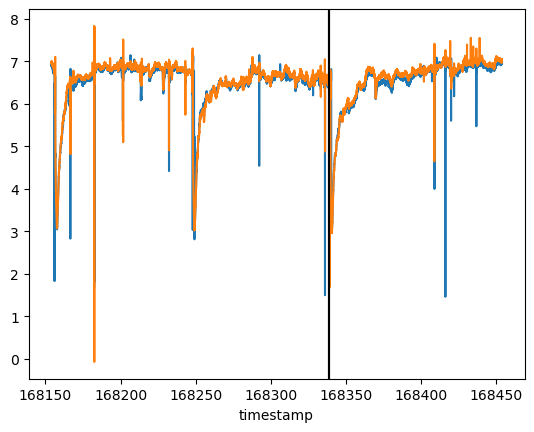

In [10]:
data = unpack_data_pandas(pgr_future.result())
data2 = unpack_data_pandas(pgr_future2.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax = data['diameter_3d'].plot()
ax.axvline(x=timestamp, color='k')
ax2 = data2['diameter_3d'].plot()
ax2.axvline(x=timestamp, color='k')
# display data from pandas table
data

In [11]:
data2

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
168153.770796,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.27805508560507847, 0.17715191842113942]",55.677599,0.926261,"{'center': [-1.368222075995472, 6.157845115342...","{'center': [87.88488716183288, 131.80603970608...","{'center': [-5.621052378218991, 8.382337999430...",6.955747,"{'center': [53.38657643617506, 157.98683166314...","[53.38657643617506, 157.98683166314123]",1.0,1.355075,-2.003073
168153.787344,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.27799128406434853, 0.1777348050515637]",55.616014,0.946166,"{'center': [-1.368222075995472, 6.157845115342...","{'center': [87.88488716183288, 131.80603970608...","{'center': [-5.622190765115189, 8.367063866528...",6.947180,"{'center': [53.374326540354915, 157.8749174300...","[53.374326540354915, 157.87491743009977]",1.0,1.356580,-2.003045
168153.800133,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.2778739480341145, 0.17812303380066974]",55.667944,0.957574,"{'center': [-1.368222075995472, 6.157845115342...","{'center': [87.88488716183288, 131.80603970608...","{'center': [-5.625330840871188, 8.357256059218...",6.954066,"{'center': [53.351798022549985, 157.8003775102...","[53.351798022549985, 157.8003775102714]",1.0,1.357545,-2.003288
168153.814170,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.27785607574538557, 0.1780169363779439]",55.740953,0.961035,"{'center': [-1.368222075995472, 6.157845115342...","{'center': [87.88488716183288, 131.80603970608...","{'center': [-5.626173474237639, 8.360233722358...",6.963979,"{'center': [53.348366543114025, 157.8207482154...","[53.348366543114025, 157.82074821543478]",1.0,1.357252,-2.003409
168153.834249,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.2775582214472647, 0.17808320935970867]",55.747556,0.928156,"{'center': [-1.368222075995472, 6.157845115342...","{'center': [87.88488716183288, 131.80603970608...","{'center': [-5.634015205764847, 8.359137636833...",6.965132,"{'center': [53.291178517874826, 157.8080238029...","[53.291178517874826, 157.80802380293594]",1.0,1.357360,-2.004249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168453.704574,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.2486750236156041, 0.23286011939743478]",55.767861,0.875559,"{'center': [-1.368222075995472, 6.157845115342...","{'center': [87.88488716183288, 131.80603970608...","{'center': [-6.385610601612333, 7.004693513329...",6.980651,"{'center': [47.745604534195984, 147.2908570756...","[47.745604534195984, 147.29085707569251]",1.0,1.489218,-2.076484
168453.724075,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.24897203198071086, 0.23294187826716728]",55.790013,0.949916,"{'center': [-1.368222075995472, 6.157845115342...","{'center': [87.88488716183288, 131.80603970608...","{'center': [-6.377770248869195, 7.001955459854...",6.983237,"{'center': [47.802630140296486, 147.2751593727...","[47.802630140296486, 147.27515937270388]",1.0,1.489482,-2.075607
168453.735596,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.24898273173072683, 0.2325116743550456]",56.075562,0.849635,"{'center': [-1.368222075995472, 6.157845115342...","{'center': [87.88488716183288, 131.80603970608...","{'center': [-6.379030494343542, 7.013144597846...",7.021934,"{'center': [47.80468449229955, 147.35775852383...","[47.80468449229955, 147.35775852383125]",1.0,1.488402,-2.075795


In [12]:
import os  

# os.makedirs('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata', exist_ok=True) 

data.to_csv(path_base + subj_base + '-eye1.csv')
data2.to_csv(path_base + subj_base + '-eye0.csv')

**DATA PROCESSING BEGINS BELOW**

In [13]:
samples = data
samples2 = data2

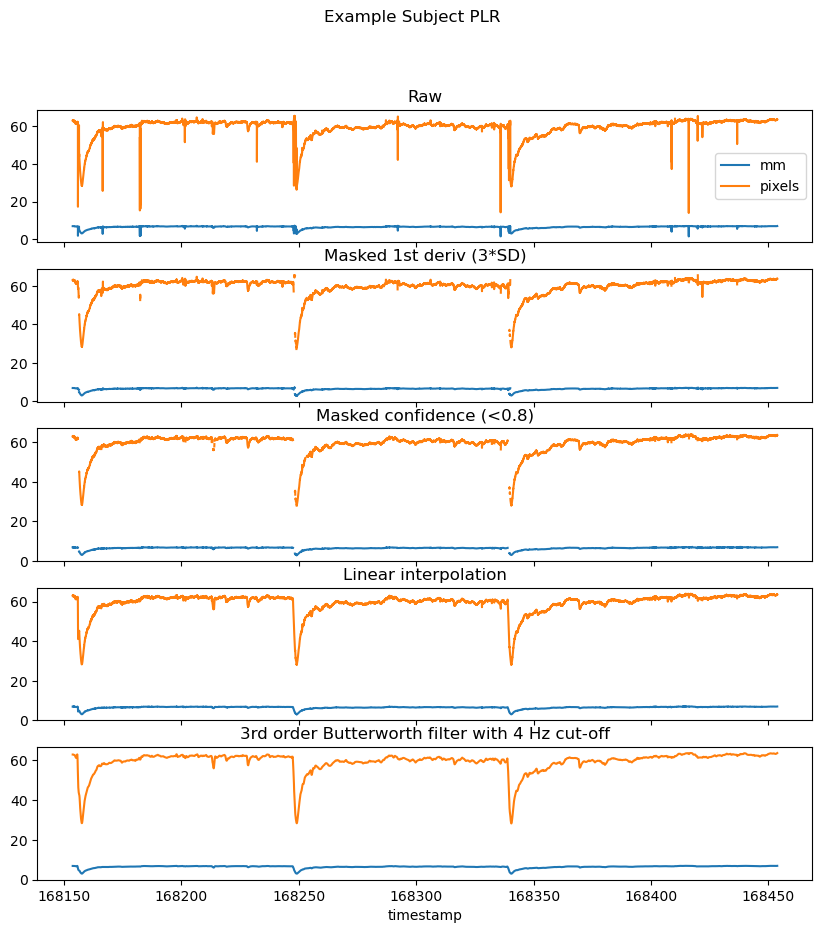

In [14]:
from pyplr import graphing
from pyplr import preproc
import matplotlib.pyplot as plt

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Example Subject PLR')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [15]:
# export butterworth processed sample data (?)
samples.to_csv(path_base + subj_base + '-butterworth-eye1.csv') # raw data
# stop here, run second protocol

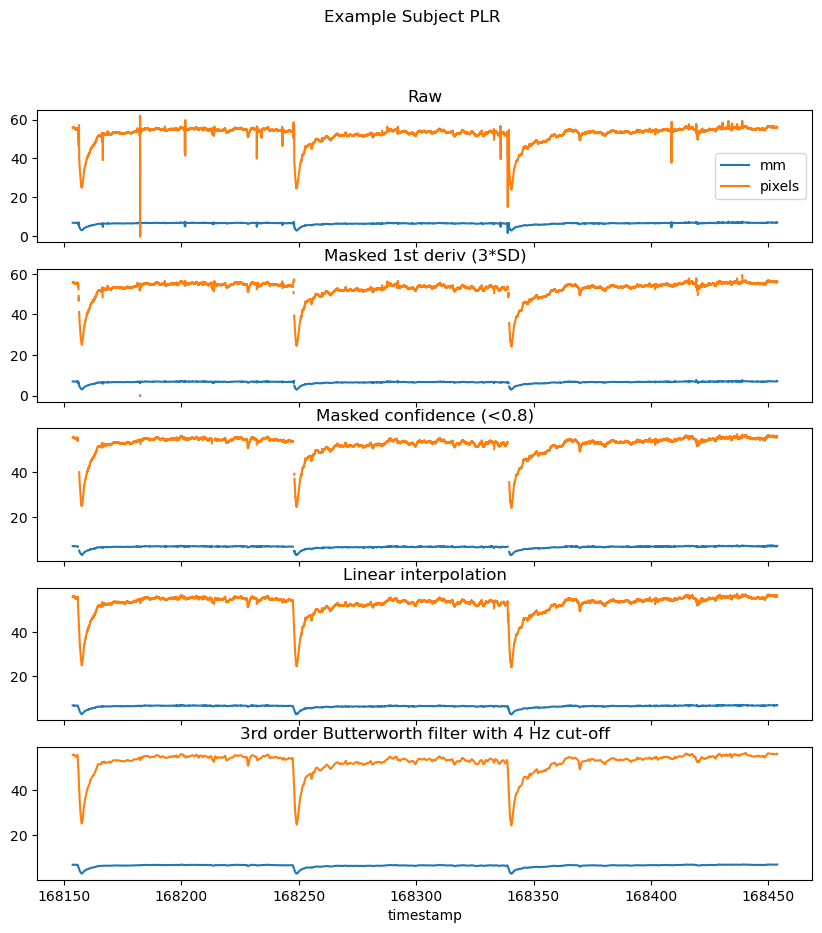

In [16]:
from pyplr import graphing
from pyplr import preproc
import matplotlib.pyplot as plt

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Example Subject PLR')

# Plot the raw data
samples2[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples2 = preproc.mask_pupil_first_derivative(
    samples2, threshold=3.0, mask_cols=pupil_cols)
samples2[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples2 = preproc.mask_pupil_confidence(
    samples2, threshold=0.8, mask_cols=pupil_cols)
samples2[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples2 = preproc.interpolate_pupil(
    samples2, interp_cols=pupil_cols)
samples2[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples2 = preproc.butterworth_series(
    samples2, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples2[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [19]:
# export butterworth processed sample data for eye 0
samples2.to_csv(path_base + subj_base + '-butterworth-eye0.csv') # raw data
# stop here, run second protocol

**STOP HERE - RUN SECOND PROGRAM**

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [20]:
# df_pipr = samples # this is the smoothed out data
df_pipr_eye0 = pd.read_csv(path_base + subj_base + '-butterworth-eye0.csv')
df_pipr_eye1 = pd.read_csv(path_base + subj_base + '-butterworth-eye1.csv')

# Print header names
print(df_pipr_eye0.columns)
print(df_pipr_eye1.columns)

# Extract the column with header "timestamp"
timestamps_eye0 = df_pipr_eye0["timestamp"]
timestamps_eye1 = df_pipr_eye1["timestamp"]
# Extract the column with header "diameter_3d"
diam_3d_eye0 = df_pipr_eye0["diameter_3d"]
diam_3d_eye1 = df_pipr_eye1["diameter_3d"]

Index(['timestamp', 'id', 'topic', 'method', 'norm_pos', 'diameter',
       'confidence', 'sphere', 'projected_sphere', 'circle_3d', 'diameter_3d',
       'ellipse', 'location', 'model_confidence', 'theta', 'phi',
       'interpolated'],
      dtype='object')
Index(['timestamp', 'id', 'topic', 'method', 'norm_pos', 'diameter',
       'confidence', 'sphere', 'projected_sphere', 'circle_3d', 'diameter_3d',
       'ellipse', 'location', 'model_confidence', 'theta', 'phi',
       'interpolated'],
      dtype='object')


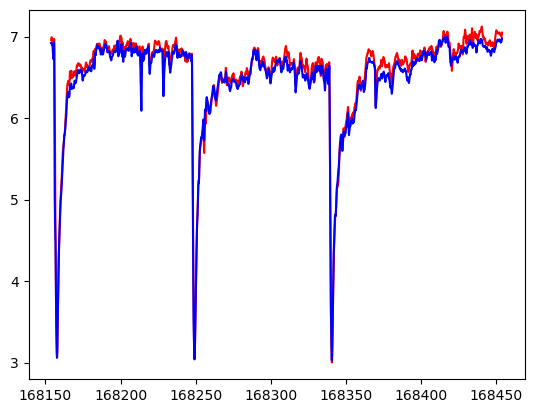

In [22]:
fig = plt.figure()
# plot eye0 in red, eye1 in blue
plt.plot(timestamps_eye0, diam_3d_eye0, 'r') # this should be the smoothed out data - if not, check
plt.plot(timestamps_eye1, diam_3d_eye1, 'b') # this should be the smoothed out data - if not, check

This is copied from the output of cell 11
> Light stamped on frame.world at 168155.858731
> Waiting for a light to stamp...
> Light stamped on frame.world at 168247.42773
> Waiting for a light to stamp...
> Light stamped on frame.world at 168338.855504

**Edit Cell Below with Timestamps**

In [23]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps_eye0 <= 168155.858731)[0][-1]
stamp2 = np.where(timestamps_eye0 <= 168247.42773)[0][-1]
stamp3 = np.where(timestamps_eye0 <= 168338.855504)[0][-1]
stamps = [stamp1, stamp2, stamp3]
stamps

[114, 5018, 9764]

In [24]:
from pyplr import utils
from copy import deepcopy

In [26]:
df_data_eye0 = df_pipr_eye0[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1 = df_pipr_eye1[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1

,timestamp,confidence,id,diameter,diameter_3d
0,168153.756911,0.930067,1,62.929792,6.920820
1,168153.780755,0.926555,1,62.930750,6.921008
2,168153.804557,0.884103,1,62.932399,6.921283
3,168153.820898,0.905433,1,62.934482,6.921614
4,168153.840129,0.962568,1,62.936743,6.921971
...,...,...,...,...,...
15844,168453.667869,1.000000,1,63.602449,6.968496
15845,168453.685863,1.000000,1,63.623040,6.971116
15846,168453.705186,1.000000,1,63.642420,6.973614
15847,168453.728880,0.953663,1,63.660347,6.975951


In [31]:
# extract ranges from samples based on event timing and sample count
# adapted from extract() from utils.py
# set variables - change as necessary
samples_eye0 = df_data_eye0
samples_eye1 = df_data_eye1
event_starts = stamps 
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs = (
    np.searchsorted(samples_eye0.index, event_starts, "left") + offset
)
range_duration = duration


In [32]:
range_idxs

array([  54, 4958, 9704], dtype=int64)

In [33]:
# make a hierarchical index
samples_eye0["orig_idx"] = samples_eye0.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye0 = pd.DataFrame()
idx = 0
for start_idx in range_idxs:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye0):
        end_idx = len(samples_eye0) - 1
    new_df_eye0 = deepcopy(
        samples_eye0.loc[samples_eye0.index[start_idx] : samples_eye0.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye0 = pd.concat([df_eye0, new_df_eye0])
    idx += 1
df_eye0.index = midx
print("Extracted ranges for {} events".format(len(event_starts)))

Extracted ranges for 3 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_25420\2697677550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_eye0["orig_idx"] = samples_eye0.index


In [34]:
df_eye0.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (2, 3590),
            (2, 3591),
            (2, 3592),
            (2, 3593),
            (2, 3594),
            (2, 3595),
            (2, 3596),
            (2, 3597),
            (2, 3598),
            (2, 3599)],
           names=['event', 'onset'], length=10800)

In [35]:
# make a hierarchical index
samples_eye1["orig_idx"] = samples_eye1.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye1 = pd.DataFrame()
idx = 0
for start_idx in range_idxs:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye1):
        end_idx = len(samples_eye1) - 1
    new_df_eye1 = deepcopy(
        samples_eye1.loc[samples_eye1.index[start_idx] : samples_eye1.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye1 = pd.concat([df_eye1, new_df_eye1])
    idx += 1
df_eye1.index = midx
print("Extracted ranges for {} events".format(len(event_starts)))

Extracted ranges for 3 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_25420\82201870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_eye1["orig_idx"] = samples_eye1.index


In [36]:
df_eye1.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (2, 3590),
            (2, 3591),
            (2, 3592),
            (2, 3593),
            (2, 3594),
            (2, 3595),
            (2, 3596),
            (2, 3597),
            (2, 3598),
            (2, 3599)],
           names=['event', 'onset'], length=10800)

In [37]:
from pyplr import graphing
from pyplr import preproc
# Calculate baselines
baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye0 = preproc.percent_signal_change(
    df_eye0, baselines_eye0, ['diameter_3d', 'diameter'])
df_eye0

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_25420\4183176285.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      168154.659259    0.935417   0  55.402642     6.920223        54   
      1      168154.675879    0.957244   0  55.386715     6.918133        55   
      2      168154.693908    0.909967   0  55.370661     6.916016        56   
      3      168154.705878    0.931263   0  55.354400     6.913861        57   
      4      168154.725507    0.956622   0  55.337855     6.911657        58   
...                    ...         ...  ..        ...          ...       ...   
2     3595   168401.209022    0.944571   0  54.353611     6.798467     13299   
      3596   168401.226531    0.899202   0  54.367248     6.800381     13300   
      3597   168401.238900    0.937339   0  54.381385     6.802352     13301   
      3598   168401.252585    0.905599   0  54.395916     6.804358     13302   
      3599   168401.264011    0.936562   0  54.410728     6.806379     13303   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0            0.271293     0.235726  
      1            0.241015     0.206911  
      2            0.210342     0.177866  
      3            0.179113     0.148446  
      4            0.147176     0.118512  
...                     ...          ...  
2     3595         3.757872     3.527012  
      3596         3.787086     3.552988  
      3597         3.817164     3.579914  
      3598         3.847788     3.607591  
      3599         3.878619     3.635802  

[10800 rows x 8 columns]

In [38]:
from pyplr.plr import PLR

average_plr_eye0 = df_eye0.mean(level=1)['diameter_3d'].to_numpy()
plr_eye0 = PLR(average_plr_eye0,
          sample_rate=60,
          onset_idx=-offset,
          stim_duration=1)

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_25420\2157588732.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  average_plr_eye0 = df_eye0.mean(level=1)['diameter_3d'].to_numpy()


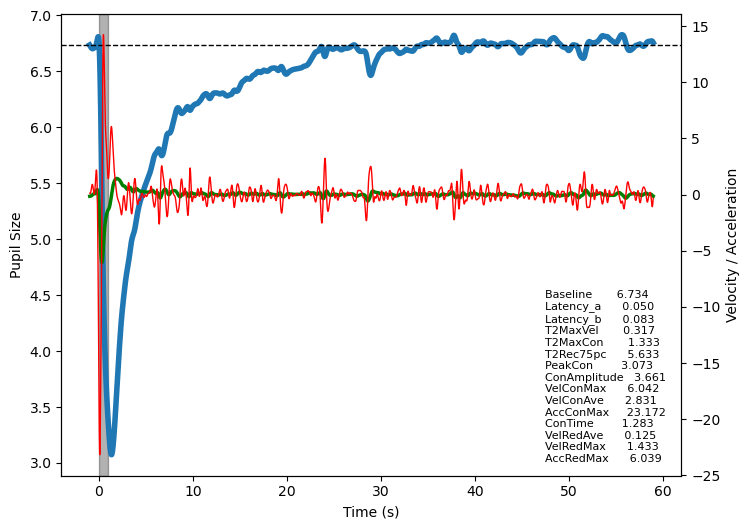

In [40]:
fig = plr_eye0.plot(vel=True, acc=True, print_params=True)
import os
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + subj_base + '-eye0.png')

In [41]:
params_eye0 = plr_eye0.parameters()
params_eye0

,value
Baseline,6.734275
Latency_a,0.050000
Latency_b,0.083333
T2MaxVel,0.316667
T2MaxCon,1.333333
T2Rec75pc,5.633333
PeakCon,3.073045
ConAmplitude,3.661230
VelConMax,6.042030
VelConAve,2.831220


In [42]:
df_eye0.to_csv(path_base + subj_base + '-processed-eye0.csv') # processed data with adjusted onset indices (time in seconds)

In [43]:
param_new_eye0=params_eye0.transpose()
param_new_eye0.reset_index(drop=True)

,Baseline,Latency_a,Latency_b,T2MaxVel,T2MaxCon,T2Rec75pc,PeakCon,ConAmplitude,VelConMax,VelConAve,AccConMax,ConTime,VelRedAve,VelRedMax,AccRedMax
0,6.734275,0.05,0.083333,0.316667,1.333333,5.633333,3.073045,3.66123,6.04203,2.83122,23.171577,1.283333,0.125054,1.432725,6.038781


In [44]:
param_new_eye0["subject_id"] = subject_id
param_new_eye0 = param_new_eye0.set_index("subject_id")
param_new_eye0.to_csv(path_base + subj_base + '-plr-params-eye0.csv') # pupillary light response calculated parameters
param_new_eye0.to_csv(path_base + 'plr-90s-params-eye0.csv') # initiate new database with all subject data (REMOVE FOR OTHER FILES)

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_25420\70192204.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye1 = df_eye1.loc[:, range(0, -offset), :].mean(level=0)
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_25420\70192204.py:8: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  average_plr_eye1 = df_eye1.mean(level=1)['diameter_3d'].to_numpy()


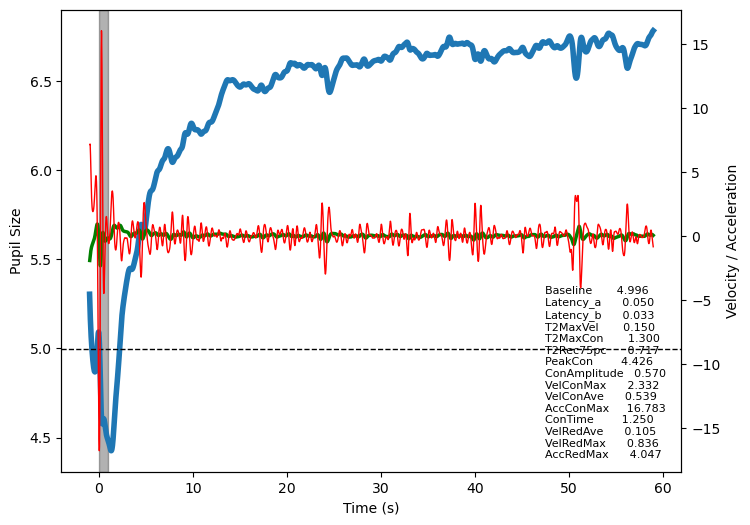

In [45]:
# Calculate baselines
baselines_eye1 = df_eye1.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye1 = preproc.percent_signal_change(
    df_eye1, baselines_eye1, ['diameter_3d', 'diameter'])
#df_eye1 # check all is correct
average_plr_eye1 = df_eye1.mean(level=1)['diameter_3d'].to_numpy()
plr_eye1 = PLR(average_plr_eye1,
          sample_rate=60,
          onset_idx=-offset,
          stim_duration=1)

fig = plr_eye1.plot(vel=True, acc=True, print_params=True)
import os
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + subj_base + '-eye1.png')

params_eye1 = plr_eye1.parameters()
params_eye1

df_eye1.to_csv(path_base + subj_base + '-processed-eye1.csv') # processed data with adjusted onset indices (time in seconds)

param_new_eye1=params_eye1.transpose()
param_new_eye1.reset_index(drop=True)

param_new_eye1["subject_id"] = subject_id
param_new_eye1 = param_new_eye1.set_index("subject_id")
param_new_eye1.to_csv(path_base + subj_base + '-plr-params-eye1.csv') # pupillary light response calculated parameters
param_new_eye1.to_csv(path_base + 'plr-90s-params-eye1.csv') # initiate new database with all subject data (REMOVE FOR OTHER FILES)

In [64]:
baselines_eyex = df_eye1.loc[:, range(0, (-20-offset)), :].mean(level=0)
baselines_eyex

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_25420\2341570059.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eyex = df_eye1.loc[:, range(0, (-20-offset)), :].mean(level=0)


,timestamp,confidence,id,diameter,diameter_3d,orig_idx,diameter_3d_pc,diameter_pc
event,,,,,,,,
0,168155.005361,0.909996,1.0,61.727160,6.783918,73.5,-0.330939,-0.317913
1,168248.767950,0.824591,1.0,31.506454,3.380789,4977.5,1.814058,1.772283
2,168342.914862,0.949902,1.0,44.695820,4.810605,9723.5,-1.057697,-1.017529


In [47]:
baselines_eye0

,timestamp,confidence,id,diameter,diameter_3d,orig_idx
event,,,,,,
0,168155.221202,0.926761,0.0,55.272351,6.901500,83.5
1,168246.836560,0.891771,0.0,54.101464,6.749084,4987.5
2,168338.286274,0.922216,0.0,52.501864,6.552242,9733.5
